In [1]:
# 학습 데이터는 512x512가 30개의 프레임
# 30개의 프레임을 하나의 프레임씩 따로 저장할 수 있게 해보자

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# 데이터 불러오기

dir_data = './datasets/UNet'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

# 학습 데이터 픽셀 수
print(ny, nx)
# 학습 데이터 프레임 수
print(nframe)

512 512
30


In [7]:
# 데이터를 학습용, 검증용, 테스트용으로 나누어 저장
nframe_train = 24
nframe_val = 3
nframe_test = 3

# 데이터가 저장될 디렉터리 설정
dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

# 디렉터리 생성
if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

In [8]:
# 실제 데이터들을 랜덤하게 저장하기 위해 랜덤 인덱스를 설정
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

In [9]:
# 실제 데이터셋 저장
# 먼저 학습 데이터
offset_nframe = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

# 검증 데이터
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)

# 테스트 데이터
offset_nframe = nframe_train + nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

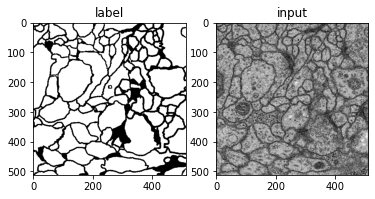

In [10]:
plt.subplot(121)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()
# 왼쪽이 segmentation map, 오른쪽이 입력 이미지

In [12]:
## 라이브러리 추가하기
import argparse

import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets

In [13]:
# 하이퍼 파라미터 설정
lr = 1e-3
batch_size = 4
num_epoch = 100

data_dir = './datasets/UNet'
ckpt_dir = './checkpoint'
log_dir = './log'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# 네트워크 구축하기
class UNet(nn.Module) :
    def __init__(self) :
        super(UNet, self).__init__()
        
        # 파란색 화살표 구현 (컨볼루션, 배치정규화, ReLU)
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr
        
        # Contracting path
        # enc는 인코더 파트의 레이어를 뜻함
        # enc 처믐 숫자는 enc의 몇 번째 단계인지 알려주고
        # 두 번째 숫자는 그 단계에서 몇 번째 화살표인지 알려준다.
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)
        
        # Expansive path
        # 이름을 contracting path와 대칭되게 지음
        # 입력 채널이 2 * 가 되는 이유는 concatenate 연결 때문이다.
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        
        # 마지막의 1x1 컨볼루션 레이어
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        
    # 정의한 레이어들을 연결해보자.
    # x는 input image이다.
    def forward(self, x) :
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        # concatenation 회색 화살표 dim=1은 채널 방향을 뜻한다.
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        # concatenation 회색 화살표 dim=1은 채널 방향을 뜻한다.
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        # concatenation 회색 화살표 dim=1은 채널 방향을 뜻한다.
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        # concatenation 회색 화살표 dim=1은 채널 방향을 뜻한다.
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x